### **This notebook starts after line 19**

* All the lines of codes prior to 19 are needed to continue pre-processing step required on Milestone II
* For complete EDA refer to Milestone I, presentation and notebook

### **Import necessary libraries**

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import os
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist
from scipy.spatial.distance import pdist
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import power_transform

from scipy.stats import zscore

from sklearn.decomposition import PCA

from scipy import stats 

In [28]:
#getting files location
url = "C:\\Users\\marce\\5.Capstone"

### **Read the dataset**

In [29]:
#creating files pathes
path1 = "\\Aviation_Marketing_Project_Flight_data.csv"
path2 = "\\Aviation_Marketing_Project_Survey_data.csv"
path3 = "\\Aviation_Marketing_Project_Data_Dictionary.csv"

In [30]:
# I'm now going to look at 10 random rows
# I'm setting the random seed via np.random.seed so that
# I get the same random results every time
np.random.seed(1)

In [31]:
#reading files and printing Dataframe shape
data = pd.read_csv(url+path1,index_col='CustomerID')
print(f'In "data" dataframe there are {data.shape[0]} rows and {data.shape[1]} columns.')  # f-string
survey = pd.read_csv(url+path2,index_col='CustomerId')
print(f'In "survey" dataframe there are {survey.shape[0]} rows and {survey.shape[1]} columns.')  # f-string
dic = pd.read_csv(url+path3)

In "data" dataframe there are 90917 rows and 8 columns.
In "survey" dataframe there are 90917 rows and 15 columns.


In [32]:
data.columns

Index(['Gender', 'CustomerType', 'Age', 'TypeTravel', 'Class',
       'Flight_Distance', 'DepartureDelayin_Mins', 'ArrivalDelayin_Mins'],
      dtype='object')

In [33]:
#Correcting columns names for futher processing
data.columns=['Gender', 'Customer_Type', 'Age', 'Type_Travel', 'Class',
       'Flight_Distance', 'Departure_Delayin_Mins', 'Arrival_Delayin_Mins']

In [34]:
#Correcting columns names for futher processing
survey.columns=['Satisfaction', 'Seat_Comfort',
       'Departure_Arrival_Time_Convenient', 'Food_Drink', 'Gate_Location',
       'Inflight_Wifi_Service', 'Inflight_Entertainment', 'Online_Support',
       'Ease_of_Online_Booking', 'Onboard_Service', 'Leg_Room_Service',
       'Baggage_Handling', 'Checkin_Service', 'Cleanliness',
       'Online_Boarding']

In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90917 entries, 149965 to 240881
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Gender                  90917 non-null  object 
 1   Customer_Type           81818 non-null  object 
 2   Age                     90917 non-null  int64  
 3   Type_Travel             81829 non-null  object 
 4   Class                   90917 non-null  object 
 5   Flight_Distance         90917 non-null  int64  
 6   Departure_Delayin_Mins  90917 non-null  int64  
 7   Arrival_Delayin_Mins    90633 non-null  float64
dtypes: float64(1), int64(3), object(4)
memory usage: 6.2+ MB


In [36]:
#Renaming Indexes
data = data.rename_axis("Customer_Id")

In [37]:
#Renaming Indexes
survey = survey.rename_axis("Customer_Id")

In [192]:
#Merge two dataframes based on "CustomerId" common column
df = pd.merge(data, survey, left_index=True, right_index=True)

In [39]:
#Getting Info
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90917 entries, 149965 to 240881
Data columns (total 23 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Gender                             90917 non-null  object 
 1   Customer_Type                      81818 non-null  object 
 2   Age                                90917 non-null  int64  
 3   Type_Travel                        81829 non-null  object 
 4   Class                              90917 non-null  object 
 5   Flight_Distance                    90917 non-null  int64  
 6   Departure_Delayin_Mins             90917 non-null  int64  
 7   Arrival_Delayin_Mins               90633 non-null  float64
 8   Satisfaction                       90917 non-null  object 
 9   Seat_Comfort                       90917 non-null  object 
 10  Departure_Arrival_Time_Convenient  82673 non-null  object 
 11  Food_Drink                         82736 non-nul

In [40]:
# Correcting data types to categories
x = df.columns
for i in x:
    if  df[i].dtype == 'object':
        df[i] = df[i].astype('category')

### **Pre-Processing Step 1**

In [41]:
#Creating a copy to start changing the data. Original dataset
#was kept to quicker access if needed.
df_p = df.copy()

**Information:**
- As it was observed in the dataset "survey" and by comparing to information file "dic", variable index to be converted from categorical to numerial starts from 2 up to 15.

In [42]:
#Creating a list of numbers with required range
index_interate = [i for i in range(9,23,1)]

In [43]:
#checking list
index_interate

[9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]

In [44]:
#numerical value 5 index from dataset "survey" is the only one 
#which the following code will no apply. It will be treated separate.
(index_interate.pop(3))
index_interate

[9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]

In [45]:
df_p.columns[1]

'Customer_Type'

In [46]:
#Getting column names from the index_interate var
#in order to run next lines
col_interate = []
for i in index_interate:
    x = df_p.columns[i]
    col_interate.append(x)
print(col_interate)  

['Seat_Comfort', 'Departure_Arrival_Time_Convenient', 'Food_Drink', 'Inflight_Wifi_Service', 'Inflight_Entertainment', 'Online_Support', 'Ease_of_Online_Booking', 'Onboard_Service', 'Leg_Room_Service', 'Baggage_Handling', 'Checkin_Service', 'Cleanliness', 'Online_Boarding']


In [47]:
# Converting catergorical to numerical variables
dic_conv = {"extremely poor":0,"poor":1,"need improvement":2,"acceptable":3,"good":4,"excellent":5}
for i in filter(None, col_interate):
    df_p[i]=df_p[i].map(dic_conv).astype('float')

In [48]:
# Converting categorical to numerical for separate variable 'Gate_location'
dic2_conv = {"very inconvinient":0,"Inconvinient":1,"need improvement":2,"manageable":3,"Convinient":4,"very convinient":5}
df_p['Gate_Location']=df_p['Gate_Location'].map(dic2_conv).astype('float')

In [49]:
#Export notebook to HTML type.
#os.system('jupyter nbconvert --to html Capstone_Aviation_Marketing_Project.ipynb')

In [50]:
#Dropping unwanted variable "Customer Id"
#df_p = df_p.drop(['Customer_Id'], axis=1)

In [51]:
#Checking first 5 lines from dataset
df_p.head()

,Gender,Customer_Type,Age,Type_Travel,Class,Flight_Distance,Departure_Delayin_Mins,Arrival_Delayin_Mins,Satisfaction,Seat_Comfort,...,Inflight_Wifi_Service,Inflight_Entertainment,Online_Support,Ease_of_Online_Booking,Onboard_Service,Leg_Room_Service,Baggage_Handling,Checkin_Service,Cleanliness,Online_Boarding
Customer_Id,,,,,,,,,,,,,,,,,,,,,
149965,Female,Loyal Customer,65,Personal Travel,Eco,265,0,0.0,satisfied,0.0,...,2.0,4.0,2.0,3.0,3.0,0.0,3.0,5.0,3.0,2.0
149966,Female,Loyal Customer,15,Personal Travel,Eco,2138,0,0.0,satisfied,0.0,...,2.0,0.0,2.0,2.0,NaN,3.0,4.0,4.0,4.0,2.0
149967,Female,Loyal Customer,60,Personal Travel,Eco,623,0,0.0,satisfied,0.0,...,3.0,4.0,3.0,1.0,1.0,0.0,1.0,4.0,1.0,3.0
149968,Female,Loyal Customer,70,Personal Travel,Eco,354,0,0.0,satisfied,0.0,...,4.0,3.0,4.0,2.0,2.0,0.0,2.0,4.0,2.0,5.0
149969,Male,Loyal Customer,30,NaN,Eco,1894,0,0.0,satisfied,0.0,...,2.0,0.0,2.0,2.0,5.0,4.0,5.0,5.0,4.0,2.0


In [52]:
#getting information from dataset
df_p.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90917 entries, 149965 to 240881
Data columns (total 23 columns):
 #   Column                             Non-Null Count  Dtype   
---  ------                             --------------  -----   
 0   Gender                             90917 non-null  category
 1   Customer_Type                      81818 non-null  category
 2   Age                                90917 non-null  int64   
 3   Type_Travel                        81829 non-null  category
 4   Class                              90917 non-null  category
 5   Flight_Distance                    90917 non-null  int64   
 6   Departure_Delayin_Mins             90917 non-null  int64   
 7   Arrival_Delayin_Mins               90633 non-null  float64 
 8   Satisfaction                       90917 non-null  category
 9   Seat_Comfort                       90917 non-null  float64 
 10  Departure_Arrival_Time_Convenient  82673 non-null  float64 
 11  Food_Drink                         

## **Milestone II**

###  1.**Data Preparation**

### **1.1 Case Study (1)**

### **1.1.1 Checking for duplicates**

In [53]:
# Check for duplicate data

dups = df_p.duplicated()
print('Number of duplicate rows = %d' % (dups.sum()))

print('Number of duplicate rows =',dups.sum())

df_p[dups]

Number of duplicate rows = 0
Number of duplicate rows = 0


,Gender,Customer_Type,Age,Type_Travel,Class,Flight_Distance,Departure_Delayin_Mins,Arrival_Delayin_Mins,Satisfaction,Seat_Comfort,...,Inflight_Wifi_Service,Inflight_Entertainment,Online_Support,Ease_of_Online_Booking,Onboard_Service,Leg_Room_Service,Baggage_Handling,Checkin_Service,Cleanliness,Online_Boarding
Customer_Id,,,,,,,,,,,,,,,,,,,,,


**Observation**
- No duplicates were found.

### **1.1.2 Checking for Outliers**

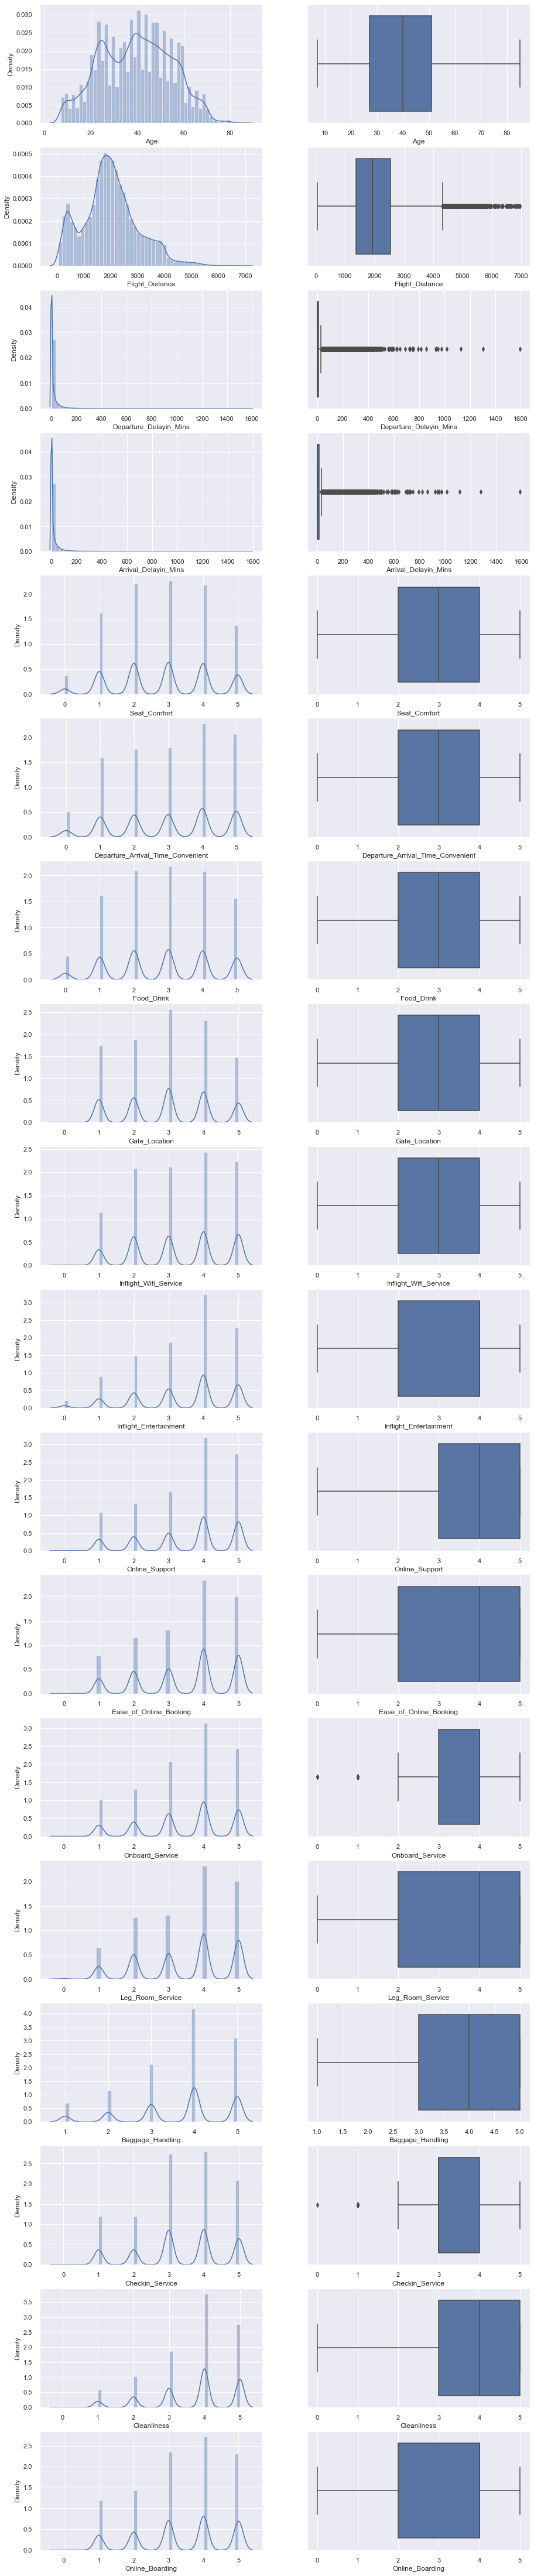

In [54]:
#Checking for Outliers
all_col_x = df_p.select_dtypes(include=np.number).columns.tolist()
#all_col_x.remove('Customer_Id')
sns.set(font_scale=1.0)

a=1
plt.figure(figsize=(15,80))
for i in all_col_x:
        plt.subplot(18,2,a)
        sns.distplot(df_p[i])
        #plt.title("Histogram for:" + i)
        plt.subplot(18,2,a+1)
        sns.boxplot(df_p[i])
       # plt.title("Boxplot for:" + i)
        a+=2
        

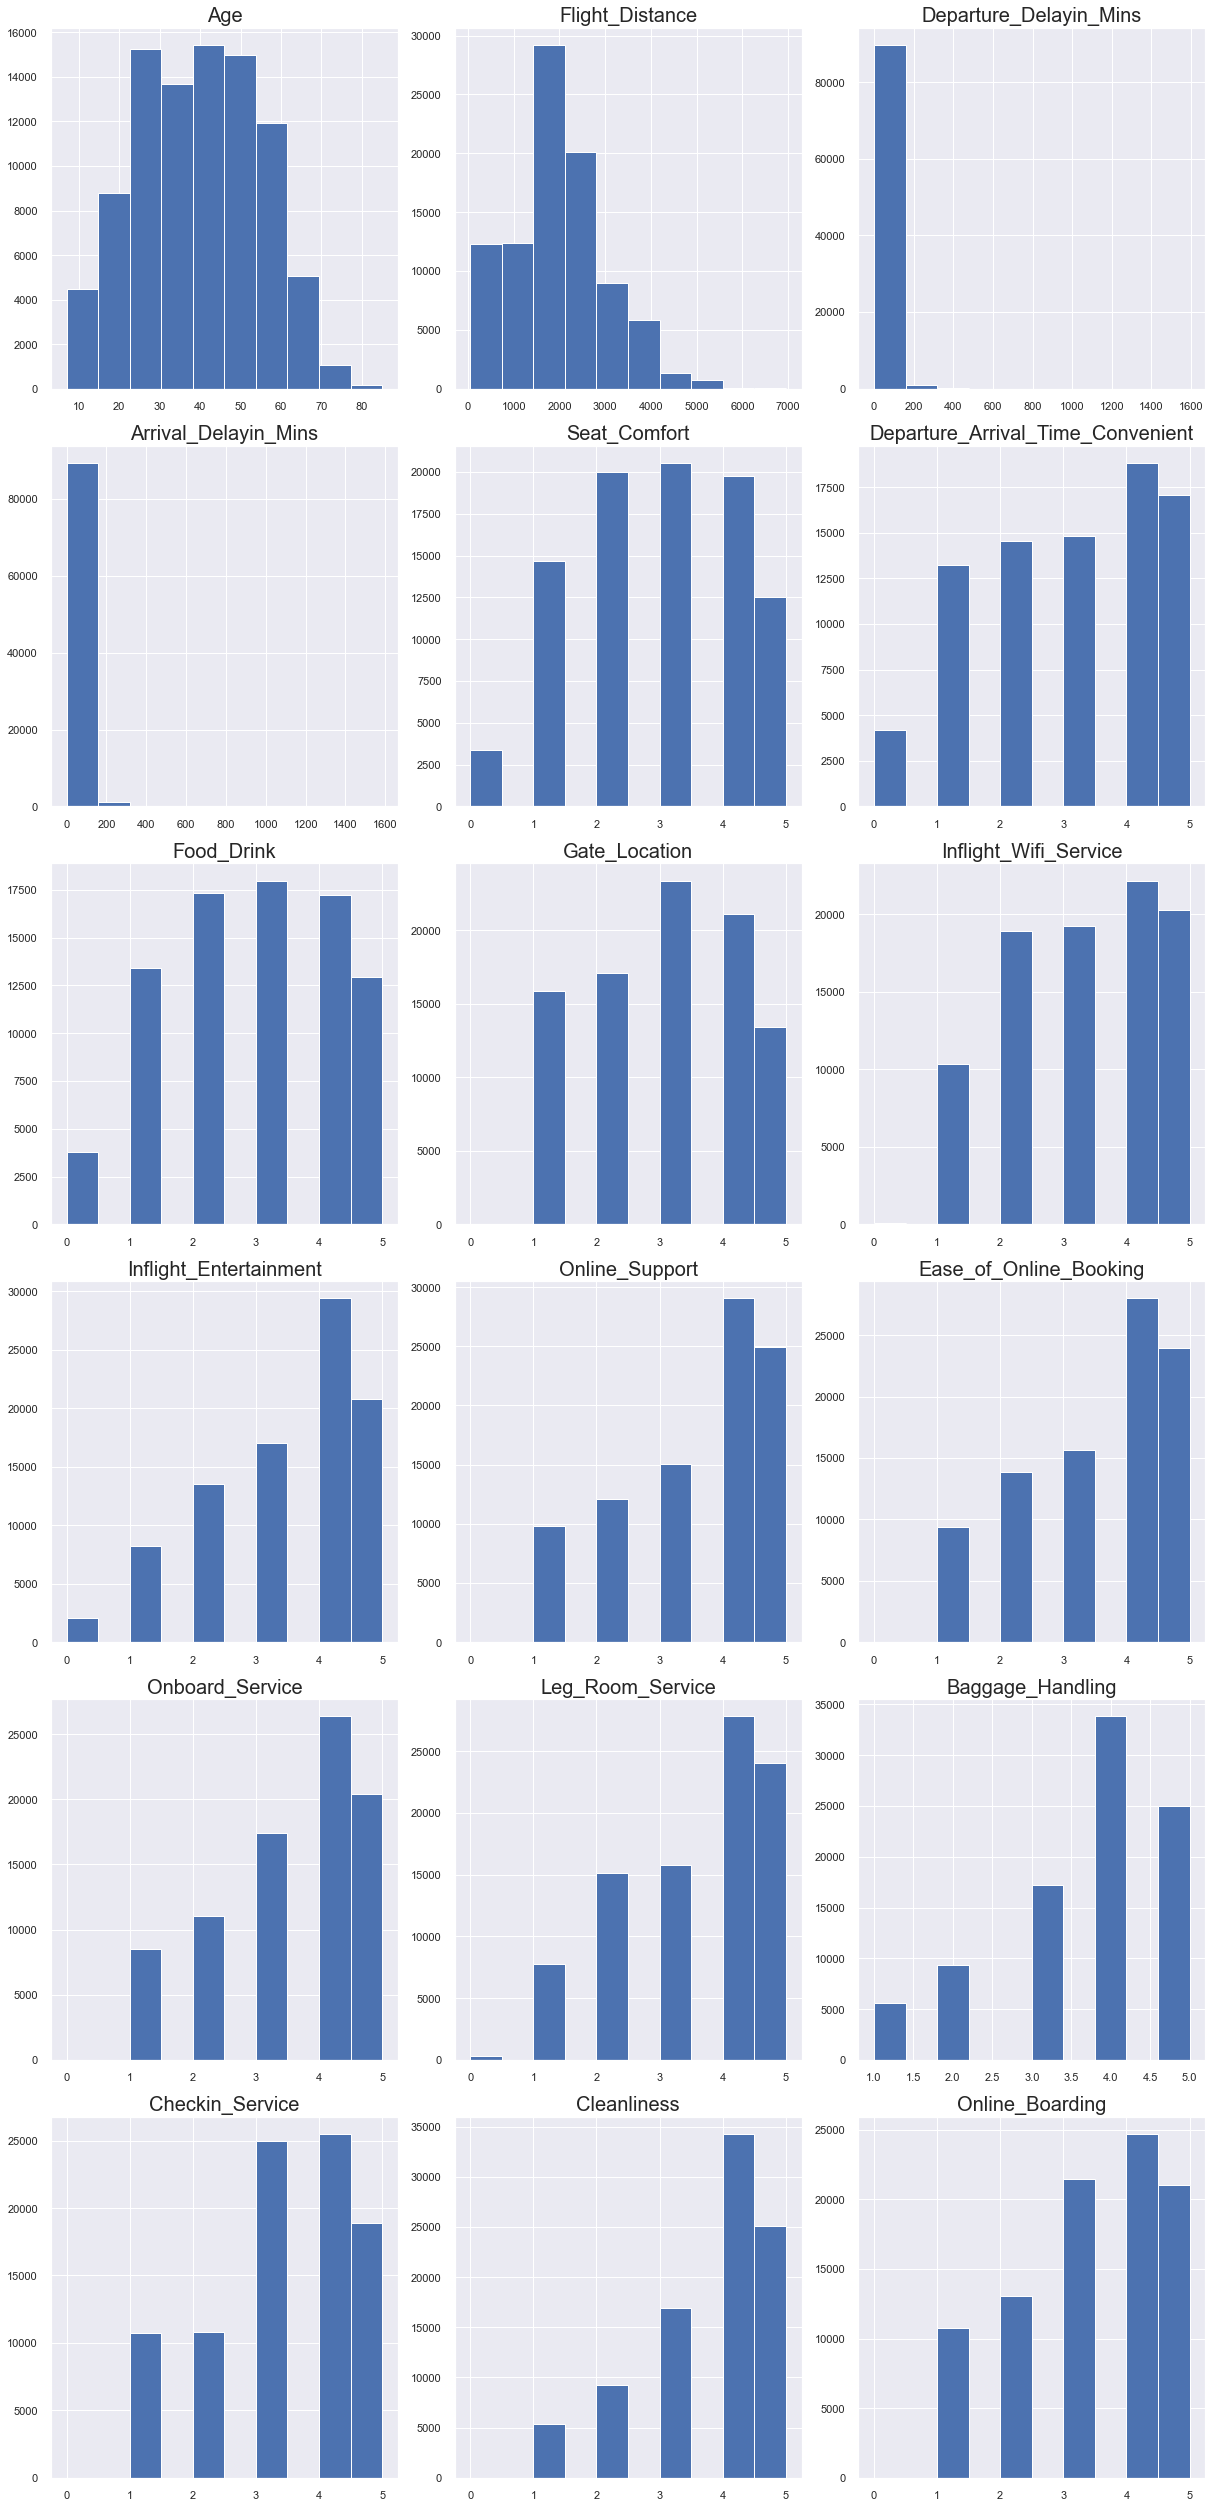

In [55]:
#plotting set of subplots for each numerical variable
sns.set(font_scale=1.0)
all_col_x1 = df_p.select_dtypes(include=np.number).columns.tolist()
#all_col_x1.remove('Customer_Id')
plt.figure(figsize=(17,35))

for i in range(len(all_col_x1)):
    plt.subplot(6,3,i+1)
    plt.hist(df_p[all_col_x1[i]])
    #sns.displot(loan[all_col[i]], kde=True)
    plt.tight_layout()
    plt.title(all_col_x1[i],fontsize=20)

plt.show()

In [56]:
df_p[df_p.Checkin_Service < 2].head(3)

,Gender,Customer_Type,Age,Type_Travel,Class,Flight_Distance,Departure_Delayin_Mins,Arrival_Delayin_Mins,Satisfaction,Seat_Comfort,...,Inflight_Wifi_Service,Inflight_Entertainment,Online_Support,Ease_of_Online_Booking,Onboard_Service,Leg_Room_Service,Baggage_Handling,Checkin_Service,Cleanliness,Online_Boarding
Customer_Id,,,,,,,,,,,,,,,,,,,,,
149980,Female,Loyal Customer,55,Personal Travel,Eco,2554,0,0.0,satisfied,0.0,...,0.0,1.0,1.0,2.0,1.0,1.0,2.0,1.0,3.0,1.0
149983,Female,Loyal Customer,25,Personal Travel,Eco,2122,0,0.0,satisfied,0.0,...,2.0,0.0,4.0,2.0,4.0,1.0,3.0,1.0,3.0,2.0
149988,Female,Loyal Customer,42,NaN,Eco,470,2,23.0,satisfied,0.0,...,3.0,2.0,2.0,3.0,NaN,0.0,3.0,1.0,3.0,4.0


In [57]:
df_p[df_p.Onboard_Service < 2].head(3)

,Gender,Customer_Type,Age,Type_Travel,Class,Flight_Distance,Departure_Delayin_Mins,Arrival_Delayin_Mins,Satisfaction,Seat_Comfort,...,Inflight_Wifi_Service,Inflight_Entertainment,Online_Support,Ease_of_Online_Booking,Onboard_Service,Leg_Room_Service,Baggage_Handling,Checkin_Service,Cleanliness,Online_Boarding
Customer_Id,,,,,,,,,,,,,,,,,,,,,
149967,Female,Loyal Customer,60,Personal Travel,Eco,623,0,0.0,satisfied,0.0,...,3.0,4.0,3.0,1.0,1.0,0.0,1.0,4.0,1.0,3.0
149975,Male,Loyal Customer,62,Personal Travel,Eco,1695,0,0.0,satisfied,0.0,...,5.0,0.0,5.0,5.0,1.0,3.0,2.0,2.0,4.0,5.0
149979,Female,Loyal Customer,52,Personal Travel,Business,2610,0,0.0,satisfied,0.0,...,1.0,2.0,2.0,1.0,1.0,0.0,1.0,2.0,1.0,3.0


**Observation:**
- 6 entries out of 90917 are insignicant. Those Outliers will be treated on step 1.1.11

### **1.1.3 Missing value Treatment - 1st Part**

 * The following variables need treatment for missing values as can be observed later in this notebook:
     - Customer_Type, Type_Travel, Arrival_Delayin_Mins , Departure_Arrival_Time_Convenient, Food_Drink, Onboard_Service

**- Process Definition:**
 * First step being the missing value treatment of a single variable. This process was needed at this stage to allow Outliers treatment by using K-Means since this algorithm does not accept missing values. 
 * Outliers will be tackled next since missing values treatment will be done with KNN and it requires (train and test) dataset treatment separatedely. After some back and forth related to what comes first this was the most effective way i found to proceed.

In [58]:
df_p.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90917 entries, 149965 to 240881
Data columns (total 23 columns):
 #   Column                             Non-Null Count  Dtype   
---  ------                             --------------  -----   
 0   Gender                             90917 non-null  category
 1   Customer_Type                      81818 non-null  category
 2   Age                                90917 non-null  int64   
 3   Type_Travel                        81829 non-null  category
 4   Class                              90917 non-null  category
 5   Flight_Distance                    90917 non-null  int64   
 6   Departure_Delayin_Mins             90917 non-null  int64   
 7   Arrival_Delayin_Mins               90633 non-null  float64 
 8   Satisfaction                       90917 non-null  category
 9   Seat_Comfort                       90917 non-null  float64 
 10  Departure_Arrival_Time_Convenient  82673 non-null  float64 
 11  Food_Drink                         

In [59]:
#Check percentage of missing values
pd.DataFrame(data={'% of Missing Values':round(df_p.isna().sum()/df_p.isna().count()*100,3)})

,% of Missing Values
Gender,0.000
Customer_Type,10.008
Age,0.000
Type_Travel,9.996
Class,0.000
Flight_Distance,0.000
Departure_Delayin_Mins,0.000
Arrival_Delayin_Mins,0.312
Satisfaction,0.000
Seat_Comfort,0.000


In [60]:
#Looking for Unique Values
df_p.nunique()

Gender                                  2
Customer_Type                           2
Age                                    75
Type_Travel                             2
Class                                   3
Flight_Distance                      5213
Departure_Delayin_Mins                436
Arrival_Delayin_Mins                  445
Satisfaction                            2
Seat_Comfort                            6
Departure_Arrival_Time_Convenient       6
Food_Drink                              6
Gate_Location                           6
Inflight_Wifi_Service                   6
Inflight_Entertainment                  6
Online_Support                          6
Ease_of_Online_Booking                  6
Onboard_Service                         6
Leg_Room_Service                        6
Baggage_Handling                        5
Checkin_Service                         6
Cleanliness                             6
Online_Boarding                         6
dtype: int64

In [61]:
#Looking for missing values sum
df_p.isnull().sum()

Gender                                  0
Customer_Type                        9099
Age                                     0
Type_Travel                          9088
Class                                   0
Flight_Distance                         0
Departure_Delayin_Mins                  0
Arrival_Delayin_Mins                  284
Satisfaction                            0
Seat_Comfort                            0
Departure_Arrival_Time_Convenient    8244
Food_Drink                           8181
Gate_Location                           0
Inflight_Wifi_Service                   0
Inflight_Entertainment                  0
Online_Support                          0
Ease_of_Online_Booking                  0
Onboard_Service                      7179
Leg_Room_Service                        0
Baggage_Handling                        0
Checkin_Service                         0
Cleanliness                             0
Online_Boarding                         0
dtype: int64

**Information:**
- For variable Arrival_Delayin_Mins since it has almost an insignificant amount of missing values 284, 
replace them by medium Values will be the chosen approach. One variable was selected Departure_Delayin_Mins to be part of this process.This variable is highly correlated to Arrival_Delayin_Min and by grouping it and getting the median of the grouped rows it can lower the variability of the target variables.
- Concerns with data leakeage will be neglected since this variable represent 0.312% of the data set

### **1.1.4 Median value input**

In [62]:
#Checking median value for the most correlated variable of 'Departure_Delayin_Mins' 
df_p.groupby(["Departure_Delayin_Mins"], as_index=False)["Arrival_Delayin_Mins"].median()

,Departure_Delayin_Mins,Arrival_Delayin_Mins
0,0,0.0
1,1,0.0
2,2,0.0
3,3,0.0
4,4,0.0
...,...,...
431,978,970.0
432,1017,1011.0
433,1128,1115.0
434,1305,1280.0


In [63]:
# Impute missing in Arrival_Delayin_Min
df_p["Arrival_Delayin_Mins"] = df_p.groupby(["Departure_Delayin_Mins"])["Arrival_Delayin_Mins"].transform(
    lambda x: x.fillna(x.median())
)

In [64]:
# Check 'Arrival_Delayin_Min'
df_p[df_p["Arrival_Delayin_Mins"].isnull()]

,Gender,Customer_Type,Age,Type_Travel,Class,Flight_Distance,Departure_Delayin_Mins,Arrival_Delayin_Mins,Satisfaction,Seat_Comfort,...,Inflight_Wifi_Service,Inflight_Entertainment,Online_Support,Ease_of_Online_Booking,Onboard_Service,Leg_Room_Service,Baggage_Handling,Checkin_Service,Cleanliness,Online_Boarding
Customer_Id,,,,,,,,,,,,,,,,,,,,,
217695,Male,NaN,46,Business travel,Business,4207,530,NaN,satisfied,3.0,...,4.0,4.0,4.0,3.0,3.0,5.0,5.0,4.0,4.0,4.0


In [65]:
#After verification one data point was still missing, this line below will take care of it
df_p["Arrival_Delayin_Mins"] = df_p["Arrival_Delayin_Mins"].transform(
    lambda x: x.fillna(x.median())
)

In [66]:
# Double-Check 'Arrival_Delayin_Min'
df_p[df_p["Arrival_Delayin_Mins"].isnull()]

,Gender,Customer_Type,Age,Type_Travel,Class,Flight_Distance,Departure_Delayin_Mins,Arrival_Delayin_Mins,Satisfaction,Seat_Comfort,...,Inflight_Wifi_Service,Inflight_Entertainment,Online_Support,Ease_of_Online_Booking,Onboard_Service,Leg_Room_Service,Baggage_Handling,Checkin_Service,Cleanliness,Online_Boarding
Customer_Id,,,,,,,,,,,,,,,,,,,,,


### **1.1.5 Outliers Treatment**

The following variables need treatment for outliers which was observed earlier in Milestone I.
* Age, Departure_Delayin_Mins, Arrival_Delayin_Mins, Flight_Distance

**- Process Definition:**

* The following methods are an attempt to smooth skewness or elimate outliers.
  * For Age, log transformation will be used.
  * For Departure_Delayin_Mins, Arrival_Delayin_Mins, Flight_Distance, Binning process will be used with support of clustering to find the optimal treashold for splitting.

**Lessons Learned**
- Variables Departure_Delayin_Mins, Arrival_Delayin_Mins log transformation and boxcox were used in a attempt to eliminate skewness but since their median and mean are = 0 such approach did not work.
- Working in the variable 'Age', After couple attempts with log transformation and boxcox, results did not eliminated 2 picks existent in the dataset. The plairplot was checked again and it was noticed something called gausian misture as described in detail below.

In [67]:
#Getting unique values for variable Satisfaction
df_p.Satisfaction.unique()

['satisfied', 'neutral or dissatisfied']
Categories (2, object): ['satisfied', 'neutral or dissatisfied']

In [68]:
#Splitting variable Satisfaction between their unique values and including Age
Age1 = df_p[(df_p['Satisfaction']=='satisfied') & (df_p['Age'])]
Age2 = df_p[(df_p['Satisfaction']=='neutral or dissatisfied') & (df_p['Age'])]

<AxesSubplot:xlabel='Age', ylabel='Density'>

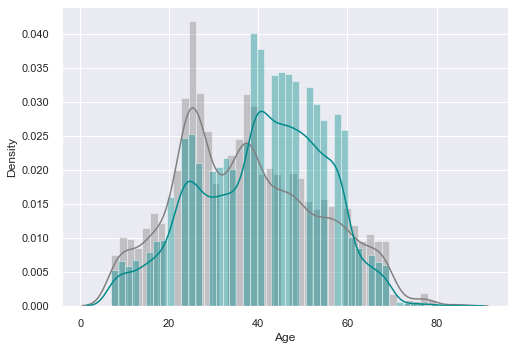

In [69]:
#Distplot showing current situation
sns.distplot(Age2['Age'],color='GREY')
sns.distplot(Age1['Age'],color='darkcyan')

**Observation:**
- Seems like there is a right skewed distribution in grey representing dissatisfied customers and another normal distribution a little left skewed in cyan reprenting satisfied. Two different behaviors in an unique variable "Age"
- This finding tells that dissastisfied customers are below 40 and satisfied are above 40.

**Choosen Approach to deal with Outliers presented in this dataset:**
* The following variables will be clustered and then binned in order to split the dataset in a more homogeneus way in an attempt to have a better normal distribution aspect.
Such task will transform numerical variables in categories.

* The clustering process will split the variables in a way where the most similar values will be clustered together and the output of such model will determine the thresholds for binning.

* Variables : Age, Departure_Delayin_Mins and Arrival_Delayin_Mins, Flight_Distance will be affected by the described process.

### **1.1.6 Clustering**

* K-Means will be used over other clustering technics since dataset is big and k_means might handle better this factor.

In [70]:
df_clust = df_p[['Age','Departure_Delayin_Mins','Arrival_Delayin_Mins','Flight_Distance']]

In [71]:
df_clust.head()

,Age,Departure_Delayin_Mins,Arrival_Delayin_Mins,Flight_Distance
Customer_Id,,,,
149965,65,0,0.0,265
149966,15,0,0.0,2138
149967,60,0,0.0,623
149968,70,0,0.0,354
149969,30,0,0.0,1894


In [72]:
# Scaling the data set before clustering
scaler=StandardScaler()
df_clust_scaled  =scaler.fit_transform(df_clust)

Number of Clusters: 1 	Average Distortion: 1.5989934492982716
Number of Clusters: 2 	Average Distortion: 1.4439300033923403
Number of Clusters: 3 	Average Distortion: 1.1742105555860813
Number of Clusters: 4 	Average Distortion: 1.0319011406959513
Number of Clusters: 5 	Average Distortion: 0.9804625796939145
Number of Clusters: 6 	Average Distortion: 0.8929938512344191
Number of Clusters: 7 	Average Distortion: 0.859825369811837
Number of Clusters: 8 	Average Distortion: 0.797257831881102


Text(0.5, 1.0, 'Selecting k with the Elbow Method')

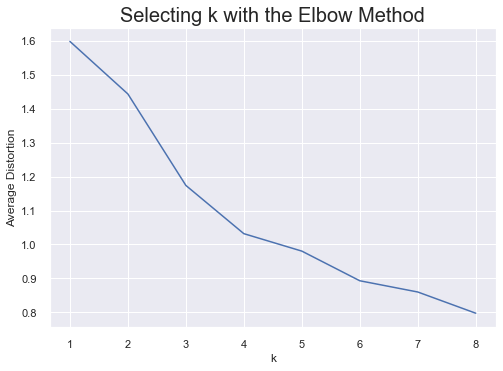

In [73]:
#Run KMeans from 0 to 9 and print coefficient
clusters=range(1,9)
meanDistortions=[]

for k in clusters:
    model=KMeans(n_clusters=k)
    model.fit(df_clust_scaled)
    prediction=model.predict(df_clust_scaled)
    distortion=sum(np.min(cdist(df_clust_scaled, model.cluster_centers_, 'euclidean'), axis=1)) / df_clust_scaled.shape[0]
                           
    meanDistortions.append(distortion)

    print('Number of Clusters:', k, '\tAverage Distortion:', distortion)

plt.plot(clusters, meanDistortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Average Distortion')
plt.title('Selecting k with the Elbow Method', fontsize=20)

**Observations**
- The appropriate value of k from elbow curve seems to between 2 and 3.
- Silhoutte Score will be used to help to define the optimal K

### **1.1.7 Shilouette to confirm K-means**
**Markdown** was used with screenshoots from output of the lines to avoid run model more than once. Each line has been taking more than 40min to run.

In [74]:
#sil_score = []
#cluster_list = list(range(2,5))
#for n_clusters in cluster_list:
#    clusterer = KMeans(n_clusters=n_clusters)
#    preds = clusterer.fit_predict((df_clust_scaled))
#    #centers = clusterer.cluster_centers_
#    score = silhouette_score(df_clust_scaled, preds)
#    sil_score.append(score)
#    print("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))

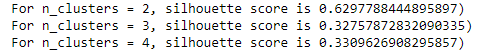

#Finding optimal no. of clusters with silhouette coefficients
#visualizer = SilhouetteVisualizer(KMeans(2, random_state = 1))
#visualizer.fit(df_clust_scaled)    
#visualizer.show()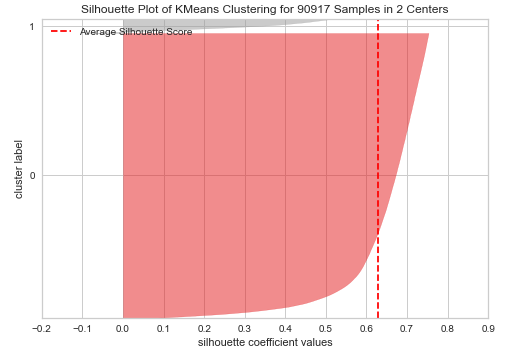

In [75]:
#Finding optimal no. of clusters with silhouette coefficients
#visualizer = SilhouetteVisualizer(KMeans(3, random_state = 1))
#visualizer.fit(df_clust_scaled)    
#visualizer.show()

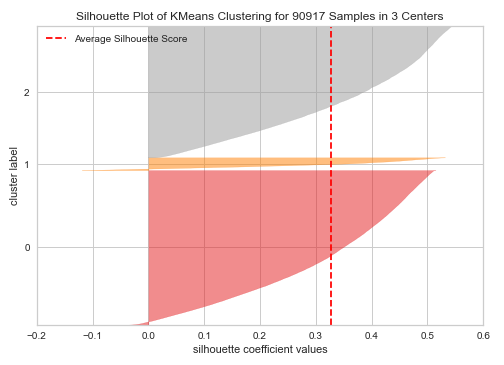

**Observation**
* 3 Clusters were selected as the optimal number for K.
    * With 2 Clusters silhouette was closer to 1 (ideal), however only one cluster was greater than the average silhouette coefficient.
    * With 3 Clusters all clusters presented were greater than the average silhouette coefficient

In [76]:
#Creating Kmeans with the selected k =3
kmeans = KMeans(n_clusters=3, n_init = 15, random_state=2345)
kmeans.fit(df_clust_scaled)

KMeans(n_clusters=3, n_init=15, random_state=2345)

#### **Adding Label to the dataset** 

In [77]:
# for inverse transformation
inversed = scaler.inverse_transform(df_clust_scaled)

In [78]:
#Creating a dataframe of the above results
df_clustered =pd.DataFrame(inversed,columns=df_clust.columns) 

In [79]:
#Checking dataset to see if inversion worked
df_clustered.head()

,Age,Departure_Delayin_Mins,Arrival_Delayin_Mins,Flight_Distance
0,65.0,0.0,0.0,265.0
1,15.0,0.0,0.0,2138.0
2,60.0,0.0,0.0,623.0
3,70.0,0.0,0.0,354.0
4,30.0,0.0,0.0,1894.0


In [80]:
#Fitting Kmeans labels to a new variable
df_clustered['Cluster_Number'] = kmeans.labels_

In [81]:
#Checking number of clusters
df_clustered.Cluster_Number.unique()

array([1, 0, 2])

**Important Information:** 
- Although KMeans overlap clusters since it does not perfectly split them, this is the best shot for binning to avoid to go blind in the definition of the thresholds to split.

In [82]:
#Checking Min, Max and Median per cluster for variable Age
df_clustered.groupby(['Cluster_Number'], sort=True)['Age'].agg(["min", "max",'median','mean','count'])

,min,max,median,mean,count
Cluster_Number,,,,,
0,7.0,69.0,28.0,29.185158,47041
1,29.0,85.0,51.0,51.581721,40014
2,7.0,80.0,39.0,38.717763,3862


* Variable **Age** will be split with respect to median in 2 groups, since group 0 and 1 are very similar they will placed  together. 
 * 7-40  (ref. cluster 0 and 2)
 * 40-85 (ref. cluster 1)

In [83]:
#Checking Min, Max and Median per cluster for variable Departure_Delayin_Mins
df_clustered.groupby(['Cluster_Number'], sort=True)['Departure_Delayin_Mins'].agg(["min", "max",'median','mean','count'])

,min,max,median,mean,count
Cluster_Number,,,,,
0,0.0,101.0,0.0,8.346613,47041
1,0.0,105.0,0.0,8.646899,40014
2,32.0,1592.0,127.0,154.487571,3862


* Variable **Departure_Delayin_Mins** does not fit well in 3 groups therefore clusters 0 and 1 will be grouped in a single cluster.
the reference for this decision is based on the "mean".
 * 0-10  (ref. cluster 0 and 1)
 * 10-1592 (ref. cluster 2)

In [84]:
#Checking Min, Max and Median per cluster for variable Arrival_Delayin_Mins
df_clustered.groupby(['Cluster_Number'], sort=True)['Arrival_Delayin_Mins'].agg(["min", "max",'median','mean','count'])

,min,max,median,mean,count
Cluster_Number,,,,,
0,0.0,141.0,0.0,8.728769,47041
1,0.0,148.0,0.0,8.936860,40014
2,0.0,1584.0,130.0,156.934749,3862


* Variable **Arrival_Delayin_Mins** does not fit well in 3 groups therefore clusters 0 and 1 will be grouped in a single cluster.
the reference for this decision is based on the "mean".
 * 0-10  (ref. cluster 0 and 1)
 * 10-1592 (ref. cluster 2)

In [85]:
#Checking Min, Max and Median per cluster for variable Age
df_clustered.groupby(['Cluster_Number'], sort=True)['Flight_Distance'].agg(["min", "max",'median','mean','count'])

,min,max,median,mean,count
Cluster_Number,,,,,
0,720.0,6950.0,2282.0,2480.343169,47041
1,50.0,5380.0,1354.0,1338.866872,40014
2,53.0,6837.0,2374.0,2566.691352,3862


* Variable **Flight_Distance** does not fit well in 3 groups therefore clusters 0 and 2 will be grouped in a single cluster.
the reference for this decision is based on the "mean".
 * 50-1350  (ref. cluster 0 and 1)
 * 1351-6950 (ref. cluster 0 and 2)

#### **Conclusion step 1.1.6**

* The idea to define the thresholds for the binning process thru the codes perfomed above had a goal in mind: eliminate Outliers by transforming numerical data and continuous variables in categorical variables and then have a data driven to drive such thresholds rather than randomly split the data or simply create a binary variable.

### **1.1.8 Binning**

**Important Information:** 
- Binning should happen before KNN since KNN is a distance-based algorithm and is very sensitive to Outliers. Although the binning process would be easier to apply after KNN with respect to execution, it is better to apply it at this point so that the performance of KNN will be improved.

In [86]:
#Binning process based on the thresholds defined previously
df_p['Age_bin'] = pd.cut(df_p['Age'], [-np.inf,40,85],labels = ["Under 40","Over 40"])
df_p['Departure_Delayin_Mins_bin'] = pd.cut(df_p['Departure_Delayin_Mins'], [-np.inf,10,1592],labels = ["Under 10","Over 10"])
df_p['Arrival_Delayin_Mins_bin'] = pd.cut(df_p['Arrival_Delayin_Mins'], [-np.inf,10,1592],labels = ["Under 10","Over 10"])
df_p['Flight_Distance_bin'] = pd.cut(df_p['Flight_Distance'], [-np.inf,1350,6950],labels = ["Under 1350","Over 1350"])


In [87]:
#Dropping original column
df_p = df_p.drop(['Age','Departure_Delayin_Mins','Arrival_Delayin_Mins','Flight_Distance'], axis=1)

In [88]:
#Checking dataset
df_p.head()

,Gender,Customer_Type,Type_Travel,Class,Satisfaction,Seat_Comfort,Departure_Arrival_Time_Convenient,Food_Drink,Gate_Location,Inflight_Wifi_Service,...,Onboard_Service,Leg_Room_Service,Baggage_Handling,Checkin_Service,Cleanliness,Online_Boarding,Age_bin,Departure_Delayin_Mins_bin,Arrival_Delayin_Mins_bin,Flight_Distance_bin
Customer_Id,,,,,,,,,,,,,,,,,,,,,
149965,Female,Loyal Customer,Personal Travel,Eco,satisfied,0.0,0.0,0.0,2.0,2.0,...,3.0,0.0,3.0,5.0,3.0,2.0,Over 40,Under 10,Under 10,Under 1350
149966,Female,Loyal Customer,Personal Travel,Eco,satisfied,0.0,0.0,0.0,3.0,2.0,...,NaN,3.0,4.0,4.0,4.0,2.0,Under 40,Under 10,Under 10,Over 1350
149967,Female,Loyal Customer,Personal Travel,Eco,satisfied,0.0,NaN,0.0,3.0,3.0,...,1.0,0.0,1.0,4.0,1.0,3.0,Over 40,Under 10,Under 10,Under 1350
149968,Female,Loyal Customer,Personal Travel,Eco,satisfied,0.0,0.0,0.0,3.0,4.0,...,2.0,0.0,2.0,4.0,2.0,5.0,Over 40,Under 10,Under 10,Under 1350
149969,Male,Loyal Customer,NaN,Eco,satisfied,0.0,0.0,0.0,3.0,2.0,...,5.0,4.0,5.0,5.0,4.0,2.0,Under 40,Under 10,Under 10,Over 1350


### **1.1.9 Missing value Treatment - 2nd Part**

**-Preparation Variables to use Imputer**
- Categoricals should be encoded to numericals

In [109]:
#Copying DataFrame 
data1=df_p.copy()

In [110]:
# we need to pass numerical values for each catergorical column for KNN imputation so we will label encode them
TypeTravel = {'Business travel':0,'Personal Travel':1}
data1['Type_Travel'] = data1['Type_Travel'].map(TypeTravel).astype('Int32')

CustomerType = {'Loyal Customer':0,'disloyal Customer':1}
data1['Customer_Type'] = data1['Customer_Type'].map(CustomerType).astype('Int32')

gender = {'Male':0,'Female':1}
data1['Gender'] = data1['Gender'].map(gender).astype('Int32')

Class = {'Business':0,'Eco':1,'Eco Plus':2 }
data1['Class'] = data1['Class'].map(Class).astype('Int32')

Age = {'Under 40':0,'Over 40':1 }
data1['Age_bin'] = data1['Age_bin'].map(Age).astype('Int32')

Dept = {'Under 10':0,'Over 10':1 }
data1['Departure_Delayin_Mins_bin'] = data1['Departure_Delayin_Mins_bin'].map(Dept).astype('Int32')

Arrival = {'Under 10':0,'Over 10':1 }
data1['Arrival_Delayin_Mins_bin'] = data1['Arrival_Delayin_Mins_bin'].map(Arrival).astype('Int32')

Flight = {'Under 1350':0,'Over 1350':1 }
data1['Flight_Distance_bin'] = data1['Flight_Distance_bin'].map(Flight).astype('Int32')

In [111]:
#Checking if encoded process worked
data1.head()

,Gender,Customer_Type,Type_Travel,Class,Satisfaction,Seat_Comfort,Departure_Arrival_Time_Convenient,Food_Drink,Gate_Location,Inflight_Wifi_Service,...,Onboard_Service,Leg_Room_Service,Baggage_Handling,Checkin_Service,Cleanliness,Online_Boarding,Age_bin,Departure_Delayin_Mins_bin,Arrival_Delayin_Mins_bin,Flight_Distance_bin
Customer_Id,,,,,,,,,,,,,,,,,,,,,
149965,1,0,1,1,satisfied,0.0,0.0,0.0,2.0,2.0,...,3.0,0.0,3.0,5.0,3.0,2.0,1,0,0,0
149966,1,0,1,1,satisfied,0.0,0.0,0.0,3.0,2.0,...,NaN,3.0,4.0,4.0,4.0,2.0,0,0,0,1
149967,1,0,1,1,satisfied,0.0,NaN,0.0,3.0,3.0,...,1.0,0.0,1.0,4.0,1.0,3.0,1,0,0,0
149968,1,0,1,1,satisfied,0.0,0.0,0.0,3.0,4.0,...,2.0,0.0,2.0,4.0,2.0,5.0,1,0,0,0
149969,0,0,<NA>,1,satisfied,0.0,0.0,0.0,3.0,2.0,...,5.0,4.0,5.0,5.0,4.0,2.0,0,0,0,1


-Values have been enconded

In [112]:
data1.isnull().sum()

Gender                                  0
Customer_Type                        9099
Type_Travel                          9088
Class                                   0
Satisfaction                            0
Seat_Comfort                            0
Departure_Arrival_Time_Convenient    8244
Food_Drink                           8181
Gate_Location                           0
Inflight_Wifi_Service                   0
Inflight_Entertainment                  0
Online_Support                          0
Ease_of_Online_Booking                  0
Onboard_Service                      7179
Leg_Room_Service                        0
Baggage_Handling                        0
Checkin_Service                         0
Cleanliness                             0
Online_Boarding                         0
Age_bin                                 0
Departure_Delayin_Mins_bin              0
Arrival_Delayin_Mins_bin                0
Flight_Distance_bin                     0
dtype: int64

**- Process Definition:**
* We will use KNN imputer to impute missing values.
* `KNNImputer`: Each sample's missing values are imputed by looking at the n_neighbors nearest neighbors found in the training set. Default value for n_neighbors=5.
* KNN imputer replaces missing values using the average of k nearest non-missing feature values.
* Nearest points are found based on euclidean distance.
* The splitting process happening next is required to avoid data leakage.

In [113]:
imputer = KNNImputer(n_neighbors=5)

In [114]:
# Sorting dataset for split
X = data1.drop(['Satisfaction'],axis=1)
y = data1['Satisfaction']

In [115]:
# Splitting data into training and test set:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7,stratify=y)
print(X_train.shape, X_test.shape)

(63641, 22) (27276, 22)


In [130]:
X_train.head()

,Gender,Customer_Type,Type_Travel,Class,Seat_Comfort,Departure_Arrival_Time_Convenient,Food_Drink,Gate_Location,Inflight_Wifi_Service,Inflight_Entertainment,...,Onboard_Service,Leg_Room_Service,Baggage_Handling,Checkin_Service,Cleanliness,Online_Boarding,Age_bin,Departure_Delayin_Mins_bin,Arrival_Delayin_Mins_bin,Flight_Distance_bin
Customer_Id,,,,,,,,,,,,,,,,,,,,,
236782,0,0,0,0,1.0,NaN,1.0,1.0,2.0,5.0,...,5.0,5.0,5.0,4.0,5.0,5.0,1,1,1,0
198324,1,0,0,1,1.0,NaN,2.0,2.0,1.0,1.0,...,2.0,1.0,3.0,1.0,4.0,1.0,0,1,1,1
232285,0,0,0,0,2.0,2.0,2.0,2.0,5.0,4.0,...,5.0,5.0,5.0,5.0,5.0,3.0,1,0,0,0
217265,1,0,0,0,1.0,1.0,1.0,1.0,4.0,4.0,...,4.0,3.0,4.0,5.0,5.0,4.0,0,1,1,1
233140,0,0,0,1,5.0,3.0,3.0,3.0,5.0,5.0,...,2.0,3.0,3.0,2.0,2.0,5.0,1,0,0,0


In [131]:
X_train_index_list = X_train.index

In [132]:
X_test_index_list = X_test.index

In [135]:
#Fit and transform the train data
X_train=pd.DataFrame(imputer.fit_transform(X_train),columns=X_train.columns, index=list(X_train_index_list))

#Transform the test data 
X_test=pd.DataFrame(imputer.transform(X_test),columns=X_test.columns, index=list(X_test_index_list))

In [137]:
#Checking that no column has missing values in train or test sets
print(X_train.isna().sum())
print('-'*30)
print(X_test.isna().sum())

Gender                               0
Customer_Type                        0
Type_Travel                          0
Class                                0
Seat_Comfort                         0
Departure_Arrival_Time_Convenient    0
Food_Drink                           0
Gate_Location                        0
Inflight_Wifi_Service                0
Inflight_Entertainment               0
Online_Support                       0
Ease_of_Online_Booking               0
Onboard_Service                      0
Leg_Room_Service                     0
Baggage_Handling                     0
Checkin_Service                      0
Cleanliness                          0
Online_Boarding                      0
Age_bin                              0
Departure_Delayin_Mins_bin           0
Arrival_Delayin_Mins_bin             0
Flight_Distance_bin                  0
dtype: int64
------------------------------
Gender                               0
Customer_Type                        0
Type_Travel         

* All missing values have been treated.
* Next, we should invert the map about the encoded values.

In [138]:
## Function to inverse the encoding
def inverse_mapping(x,y):
    inv_dict = {v: k for k, v in x.items()}
    X_train[y] = np.round(X_train[y]).map(inv_dict).astype('category')
    X_test[y] = np.round(X_test[y]).map(inv_dict).astype('category')

In [139]:
inverse_mapping(gender,'Gender')
inverse_mapping(TypeTravel,'Type_Travel')
inverse_mapping(CustomerType,'Customer_Type')
inverse_mapping(Class,'Class')
inverse_mapping(Age,'Age_bin')
inverse_mapping(Dept,'Departure_Delayin_Mins_bin')
inverse_mapping(Arrival,'Arrival_Delayin_Mins_bin')
inverse_mapping(Flight,'Flight_Distance_bin')

In [140]:
X_train.head()

,Gender,Customer_Type,Type_Travel,Class,Seat_Comfort,Departure_Arrival_Time_Convenient,Food_Drink,Gate_Location,Inflight_Wifi_Service,Inflight_Entertainment,...,Onboard_Service,Leg_Room_Service,Baggage_Handling,Checkin_Service,Cleanliness,Online_Boarding,Age_bin,Departure_Delayin_Mins_bin,Arrival_Delayin_Mins_bin,Flight_Distance_bin
236782,Male,Loyal Customer,Business travel,Business,1.0,1.0,1.0,1.0,2.0,5.0,...,5.0,5.0,5.0,4.0,5.0,5.0,Over 40,Over 10,Over 10,Under 1350
198324,Female,Loyal Customer,Business travel,Eco,1.0,2.2,2.0,2.0,1.0,1.0,...,2.0,1.0,3.0,1.0,4.0,1.0,Under 40,Over 10,Over 10,Over 1350
232285,Male,Loyal Customer,Business travel,Business,2.0,2.0,2.0,2.0,5.0,4.0,...,5.0,5.0,5.0,5.0,5.0,3.0,Over 40,Under 10,Under 10,Under 1350
217265,Female,Loyal Customer,Business travel,Business,1.0,1.0,1.0,1.0,4.0,4.0,...,4.0,3.0,4.0,5.0,5.0,4.0,Under 40,Over 10,Over 10,Over 1350
233140,Male,Loyal Customer,Business travel,Eco,5.0,3.0,3.0,3.0,5.0,5.0,...,2.0,3.0,3.0,2.0,2.0,5.0,Over 40,Under 10,Under 10,Under 1350


**- Process Definition:**
- Since for KNN inputer data was split for PCA analysis we have to have the whole dataset with exception for target variable "Satisfaction". Concatenate will be used in a way to put pieces of the original dataset back together.

### **1.1.10 Preparing DataSet for EDA and PCA**

In [141]:
#Creating 2 datasets since they sklearn split treated X as dataframe and Y as Series
#Concat cannot happen at once
df_x = [X_train, X_test]
df_y =[y_train, y_test]

In [142]:
#Creating variables with concat values, X and Y was required to do it separatedely
#bacause X was split and conserved as a dataframe and Y was kept as a series
eda_pca_df = pd.concat(df_x, ignore_index=False)
eda_pca_dfy = pd.concat(df_y, ignore_index=False)

In [143]:
#Converting series originated from Y split to dataframe
eda_satis= pd.DataFrame(eda_pca_dfy)
eda_satis.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90917 entries, 236782 to 219662
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Satisfaction  90917 non-null  category
dtypes: category(1)
memory usage: 799.2 KB


In [146]:
#Including variable Satisfaction back to dataframe
eda_pca_df ['Satisfaction'] = eda_satis['Satisfaction']
eda_pca_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90917 entries, 236782 to 219662
Data columns (total 23 columns):
 #   Column                             Non-Null Count  Dtype   
---  ------                             --------------  -----   
 0   Gender                             90917 non-null  category
 1   Customer_Type                      90917 non-null  category
 2   Type_Travel                        90917 non-null  category
 3   Class                              90917 non-null  category
 4   Seat_Comfort                       90917 non-null  float64 
 5   Departure_Arrival_Time_Convenient  90917 non-null  float64 
 6   Food_Drink                         90917 non-null  float64 
 7   Gate_Location                      90917 non-null  float64 
 8   Inflight_Wifi_Service              90917 non-null  float64 
 9   Inflight_Entertainment             90917 non-null  float64 
 10  Online_Support                     90917 non-null  float64 
 11  Ease_of_Online_Booking             

In [147]:
#Checking a ramdom row from X_train agaist new EDA dataframe
X_train.iloc[[63638]] 

,Gender,Customer_Type,Type_Travel,Class,Seat_Comfort,Departure_Arrival_Time_Convenient,Food_Drink,Gate_Location,Inflight_Wifi_Service,Inflight_Entertainment,...,Onboard_Service,Leg_Room_Service,Baggage_Handling,Checkin_Service,Cleanliness,Online_Boarding,Age_bin,Departure_Delayin_Mins_bin,Arrival_Delayin_Mins_bin,Flight_Distance_bin
169033,Female,Loyal Customer,Personal Travel,Eco,5.0,3.0,3.0,3.0,5.0,5.0,...,1.0,3.0,3.0,3.0,2.0,5.0,Over 40,Under 10,Under 10,Under 1350


In [148]:
#Checking same row from X_train agaist new EDA dataframe
eda_pca_df.iloc[[63638]]

,Gender,Customer_Type,Type_Travel,Class,Seat_Comfort,Departure_Arrival_Time_Convenient,Food_Drink,Gate_Location,Inflight_Wifi_Service,Inflight_Entertainment,...,Leg_Room_Service,Baggage_Handling,Checkin_Service,Cleanliness,Online_Boarding,Age_bin,Departure_Delayin_Mins_bin,Arrival_Delayin_Mins_bin,Flight_Distance_bin,Satisfaction
169033,Female,Loyal Customer,Personal Travel,Eco,5.0,3.0,3.0,3.0,5.0,5.0,...,3.0,3.0,3.0,2.0,5.0,Over 40,Under 10,Under 10,Under 1350,satisfied


In [195]:
#Getting new dataset to PCA excluding target variable
pca_df_sat =  eda_pca_df[['Satisfaction']]
pca_df = eda_pca_df.drop('Satisfaction',axis=1).copy()

In [196]:
pca_df_sat.head()

,Satisfaction
236782,satisfied
198324,neutral or dissatisfied
232285,satisfied
217265,satisfied
233140,satisfied


In [173]:
pca_index = pca_df.index

In [150]:
#Create dummys for all categorical variables
categorical_cols = pca_df.select_dtypes(include='category').columns.tolist()

In [151]:
#Create dummys for all categorical variables
df_ready = pd.get_dummies(pca_df, columns = categorical_cols)

In [170]:
X = df_ready.loc[:, :].values
X = StandardScaler().fit_transform(X) # normalizing the features

**Observation**
* Concatate process worked well and allowed the creation of a dataset for PCA which was already treated for missing values and outliers.

In [174]:
#Creating a dataframe for plot boxplot
df_ready_00 =pd.DataFrame(X,columns=df_ready.columns, index=list(pca_index)) 

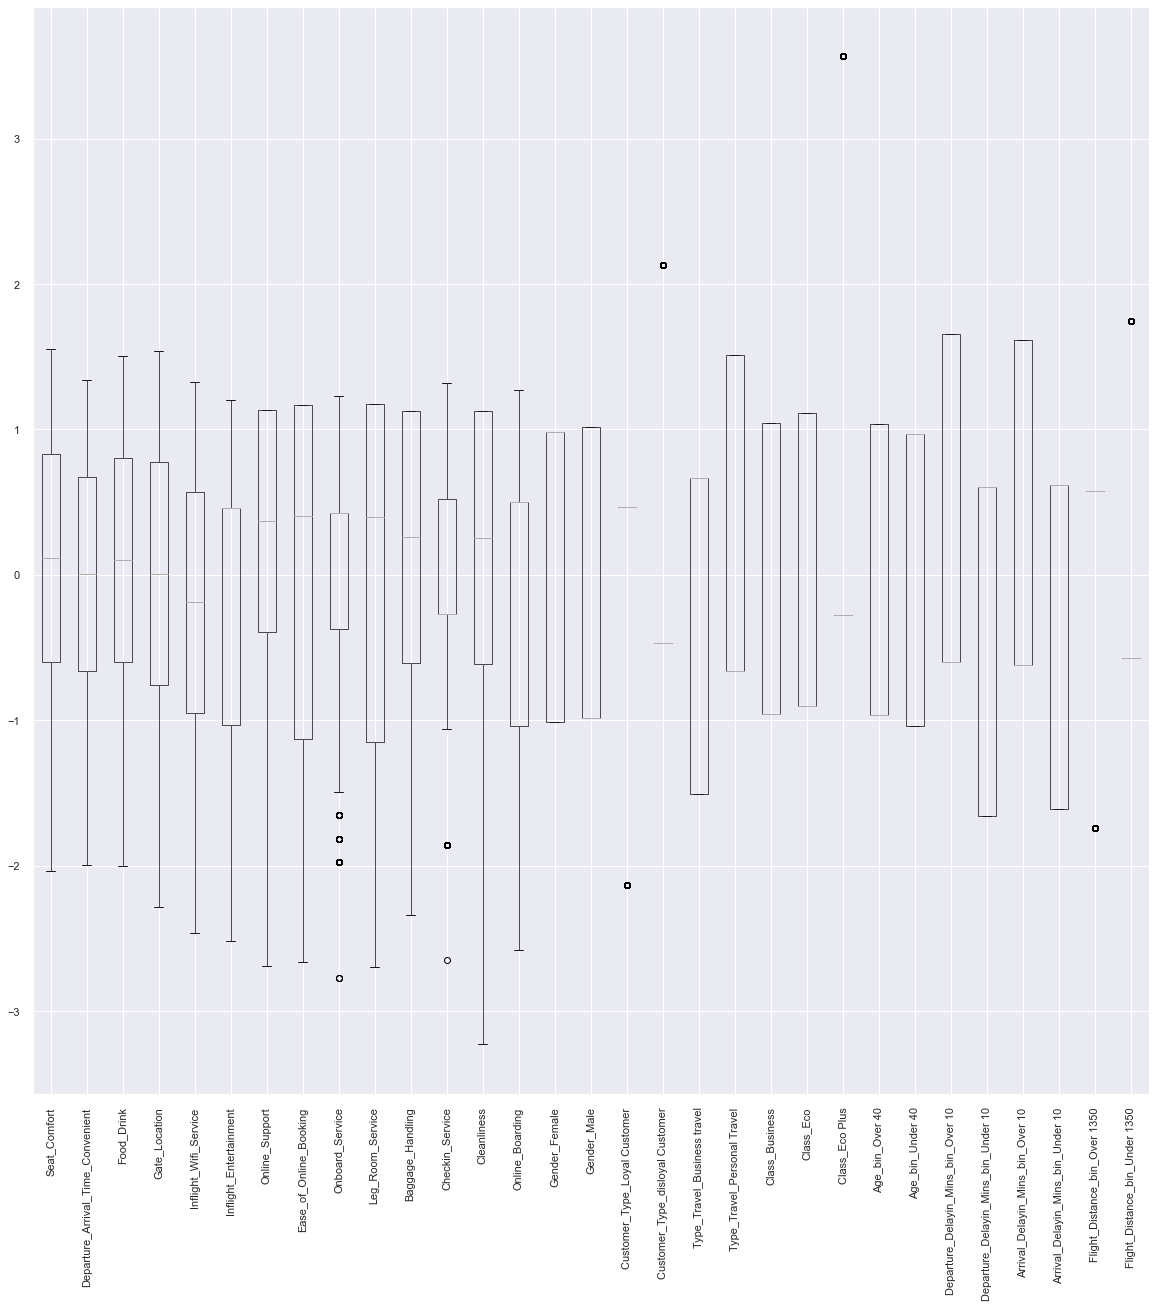

In [175]:
## Plotting Boxplot after outlier and missing values treatment
df_ready_00.boxplot(figsize=(20,20))
plt.xticks(rotation=90)
plt.show()

### **1.1.11 Treating remaining Outliers**

**- Process Definition:**
* The existent outliers will be treated by using IQR concept.

In [176]:
def remove_outlier(col):
    sorted(col)
    Q1,Q3=np.percentile(col,[25,75])
    IQR=Q3-Q1
    lower_range= Q1-(1.5 * IQR)
    upper_range= Q3+(1.5 * IQR)
    return lower_range, upper_range

In [177]:
all_col_0 = df_ready_00.select_dtypes(include=np.number).columns.tolist()
for i in all_col_0:
        lratio,uratio=remove_outlier(df_ready_00[i])
        df_ready_00[i]=np.where(df_ready_00[i]>uratio,uratio,df_ready_00[i])
        df_ready_00[i]=np.where(df_ready_00[i]<lratio,lratio,df_ready_00[i])

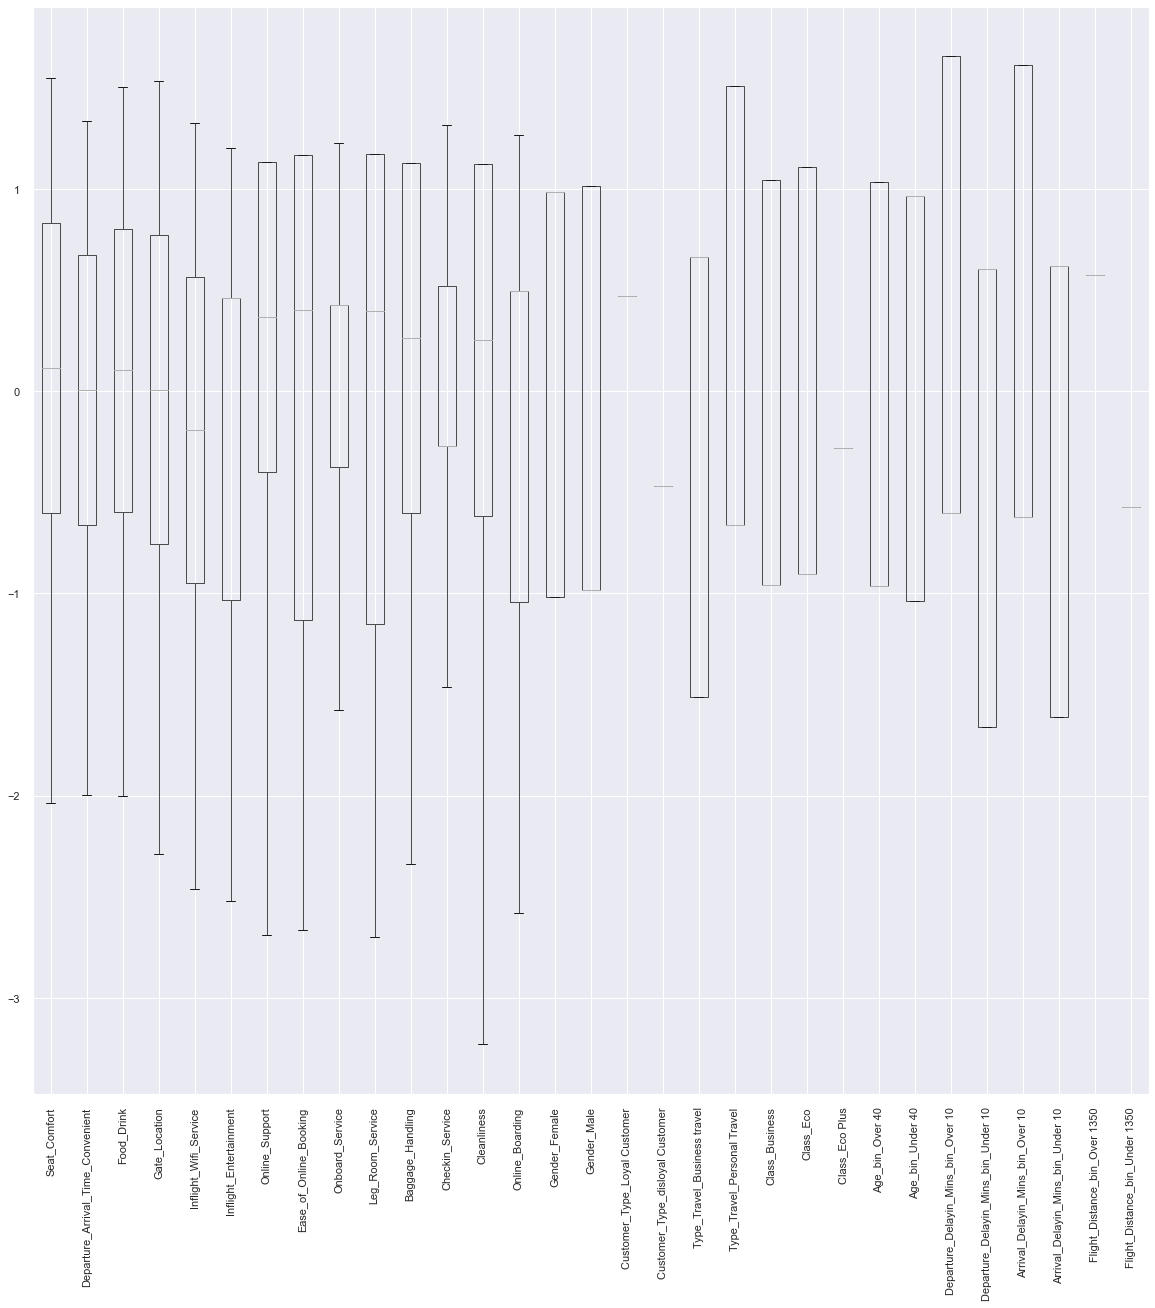

In [180]:
## Plotting Boxplot after outlier and missing values treatment
df_ready_00.boxplot(figsize=(20,20))
plt.xticks(rotation=90)
plt.show()

In [181]:
#Preparing dataset for PCA
X1 = df_ready_00.loc[:, :].values
X1 = StandardScaler().fit_transform(X) # normalizing the features

### **1.1.12 Principal Component Analysis - PCA**

**- Process Definition:**
* **PCA** is a statistical technique and uses orthogonal transformation to convert a set of observations of possibly correlated variables into a set of values of linearly uncorrelated variables. PCA also is a tool to reduce multidimensional data to lower dimensions while retaining most of the information. Principal Component Analysis (PCA) is a well-established mathematical technique for reducing the dimensionality of data, while keeping as much variation as possible.


In [184]:
#Checking number of dimensions before reduction
X1.shape

(90917, 31)

In [160]:
#Fitting PCA
pca = PCA()
pca.fit(X1)

PCA()

In [161]:
# Show variance explained by individual components
pca.explained_variance_ratio_

array([1.63108895e-01, 1.30103866e-01, 1.14557613e-01, 9.66214106e-02,
       8.28921004e-02, 7.77026261e-02, 7.41659913e-02, 4.00755926e-02,
       3.43236320e-02, 2.89519926e-02, 2.45843921e-02, 2.24485662e-02,
       1.79742298e-02, 1.74797789e-02, 1.51911929e-02, 1.40443036e-02,
       1.27943454e-02, 1.15582458e-02, 9.27515656e-03, 7.16392802e-03,
       4.98214040e-03, 1.54309252e-32, 7.04233376e-33, 6.17238040e-33,
       2.50645882e-33, 8.88966062e-34, 8.88966062e-34, 8.88966062e-34,
       8.88966062e-34, 8.88966062e-34, 8.88966062e-34])

Text(0, 0.5, 'Cumulative Explained Variance')

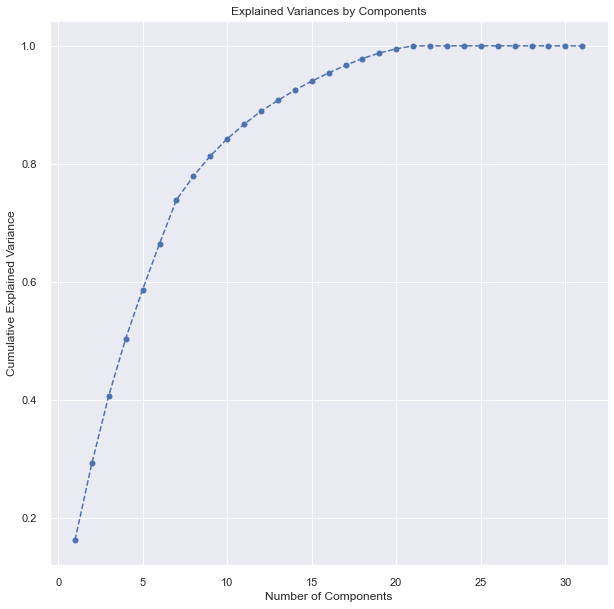

In [162]:
# visulaize the Explained Individual Components
plt.figure(figsize = (10,10))
plt.plot(range(1,32), pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '--')
plt.title("Explained Variances by Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")

In [163]:
#Adjusting PCA to output a number of variables that explain at least 90% of the dataset
pca = PCA(.9,svd_solver ='full') # svd_solver -full helps to converge faster in case of very large data set
pca.fit(X1)

PCA(n_components=0.9, svd_solver='full')

In [164]:
#coefficient of variance 
pca.explained_variance_

array([4.24087792, 3.38273772, 2.97853071, 2.51218431, 2.15521832,
       2.0202905 , 1.92833698, 1.04197687, 0.89242425, 0.75276009,
       0.63920123, 0.58366914, 0.46733511])

Text(0, 0.5, 'Cumulative Explained Variance')

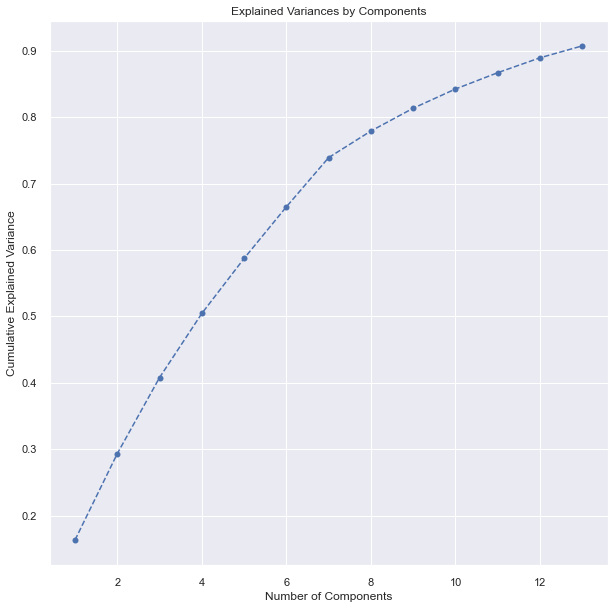

In [165]:
#plot explained variance ratio by mum of variables chosen
plt.figure(figsize = (10,10))
plt.plot(range(1,14), pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '--')
plt.title("Explained Variances by Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")

In [185]:
#Creating Dataframe for model building
df_model = pca.transform(X1)
df_model_reduced = pd.DataFrame(df_model,index=list(pca_index))

In [186]:
#Checking Dataframe
df_model_reduced.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
236782,-1.567951,3.794470,-1.602864,2.815868,-1.841168,1.391000,0.178617,0.349105,-0.999234,0.131374,-0.022836,-0.016784,0.655486
198324,5.219825,2.259217,-0.740427,0.271779,-0.041905,-2.159567,0.665783,-1.024337,0.018405,-0.374201,1.352786,0.119710,-0.088120
232285,-2.940300,-0.491563,-1.554801,1.598456,-1.710934,1.440550,-0.136577,0.177289,-0.122280,-0.568553,-0.158945,-0.020369,-0.416685
217265,-0.420443,3.552581,-1.571466,2.602566,0.295910,-2.010921,-0.292233,1.373599,0.273499,-0.411238,0.664510,0.030227,-0.203959
233140,-1.052122,-0.921931,0.065024,-0.913338,2.766227,2.679132,-0.582050,-1.454644,-1.732027,-0.433923,-0.012023,0.052139,-0.221152


In [187]:
#Correcting columns names
df_model_reduced.columns=['PCA_1', 'PCA_2', 'PCA_3', 'PCA_4', 'PCA_5', 'PCA_6',
       'PCA_7', 'PCA_8', 'PCA_9','PCA_10','PCA_11','PCA_12','PCA_13']

In [188]:
#Checking DataFrame
df_model_reduced.head()

,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10,PCA_11,PCA_12,PCA_13
236782,-1.567951,3.794470,-1.602864,2.815868,-1.841168,1.391000,0.178617,0.349105,-0.999234,0.131374,-0.022836,-0.016784,0.655486
198324,5.219825,2.259217,-0.740427,0.271779,-0.041905,-2.159567,0.665783,-1.024337,0.018405,-0.374201,1.352786,0.119710,-0.088120
232285,-2.940300,-0.491563,-1.554801,1.598456,-1.710934,1.440550,-0.136577,0.177289,-0.122280,-0.568553,-0.158945,-0.020369,-0.416685
217265,-0.420443,3.552581,-1.571466,2.602566,0.295910,-2.010921,-0.292233,1.373599,0.273499,-0.411238,0.664510,0.030227,-0.203959
233140,-1.052122,-0.921931,0.065024,-0.913338,2.766227,2.679132,-0.582050,-1.454644,-1.732027,-0.433923,-0.012023,0.052139,-0.221152


In [189]:
df_model_reduced.shape

(90917, 13)

In [190]:
eda_pca_df.shape

(90917, 23)

In [197]:
#Including variable Satisfaction back to dataframe
#Merge two dataframes based on "CustomerId" common column
df_rd = pd.merge(df_model_reduced, pca_df_sat, left_index=True, right_index=True)

In [199]:
df_rd.head()

,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10,PCA_11,PCA_12,PCA_13,Satisfaction
236782,-1.567951,3.794470,-1.602864,2.815868,-1.841168,1.391000,0.178617,0.349105,-0.999234,0.131374,-0.022836,-0.016784,0.655486,satisfied
198324,5.219825,2.259217,-0.740427,0.271779,-0.041905,-2.159567,0.665783,-1.024337,0.018405,-0.374201,1.352786,0.119710,-0.088120,neutral or dissatisfied
232285,-2.940300,-0.491563,-1.554801,1.598456,-1.710934,1.440550,-0.136577,0.177289,-0.122280,-0.568553,-0.158945,-0.020369,-0.416685,satisfied
217265,-0.420443,3.552581,-1.571466,2.602566,0.295910,-2.010921,-0.292233,1.373599,0.273499,-0.411238,0.664510,0.030227,-0.203959,satisfied
233140,-1.052122,-0.921931,0.065024,-0.913338,2.766227,2.679132,-0.582050,-1.454644,-1.732027,-0.433923,-0.012023,0.052139,-0.221152,satisfied


In [200]:
df_rd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90917 entries, 236782 to 219662
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   PCA_1         90917 non-null  float64 
 1   PCA_2         90917 non-null  float64 
 2   PCA_3         90917 non-null  float64 
 3   PCA_4         90917 non-null  float64 
 4   PCA_5         90917 non-null  float64 
 5   PCA_6         90917 non-null  float64 
 6   PCA_7         90917 non-null  float64 
 7   PCA_8         90917 non-null  float64 
 8   PCA_9         90917 non-null  float64 
 9   PCA_10        90917 non-null  float64 
 10  PCA_11        90917 non-null  float64 
 11  PCA_12        90917 non-null  float64 
 12  PCA_13        90917 non-null  float64 
 13  Satisfaction  90917 non-null  category
dtypes: category(1), float64(13)
memory usage: 12.3 MB


In [ ]:
#Getting correlation matrix
corr = df_model.corr()
plt.figure(figsize=(15 ,10))
sns.heatmap(corr, annot=True,fmt='.2f',cmap='CMRmap', vmin=-1, vmax=1)

**Conclusion:** 
* Original dataset had 32 dimensions
* After PCA technic the number of variables lower to 13.
* The output of 13 variables from PCA can explain the variace of 90% of the dataset.
* Correlation Matrix showed all the variables are indenpendent of one another which is ideal for model building.
* Dataset "df_model" us ready for model building.

###  2. **EDA - Exploratory Data Analysis**

**- Important:**
**- The Dataframe created in this step called "eda_df" will not be used for modeling, only for EDA.**

In [ ]:
#Getting new dataset to PCA exclusing target variable
eda_df = eda_pca_df.copy()

In [ ]:
#Checking dataset originated from X split
eda_df.info()

**2.1 Uni-variate analysis**

In [ ]:
all_col = eda_df.select_dtypes(include=np.number).columns.tolist()
a=1
plt.figure(figsize=(15,80))
for i in all_col:
        plt.subplot(18,2,a)
        sns.distplot(eda_df[i])
        #plt.title("Histogram for:" + i)
        plt.subplot(18,2,a+1)
        sns.boxplot(eda_df[i])
       # plt.title("Boxplot for:" + i)
        a+=2
        

In [ ]:
# Function to create barplots that indicate percentage for each category.
sns.set(font_scale=1.0)
def bar_perc(plot, feature):
    '''
    plot
    feature: 1-d categorical feature array
    '''
    total = len(feature) # length of the column
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total) # percentage of each class of the category
        x = p.get_x() + p.get_width() / 2 - 0.05 # width of the plot
        y = p.get_y() + p.get_height()           # hieght of the plot
        ax.annotate(percentage, (x, y), size = 12) # annotate the percantage

In [ ]:
# Plotting all counts of observations in each categorical variable
sns.set(font_scale=1.0)
all_cat = eda_df.select_dtypes(include='category').columns.tolist()

plt.figure(figsize=(10,120))

for i in range(len(all_cat)):
    plt.subplot(19,1,i+1)
    ax = sns.countplot(eda_df[all_cat[i]])#,palette="ch:start=.2,rot=-.3")
    bar_perc(ax,eda_df[all_cat[i]])
plt.show()

In [ ]:
#plotting set of subplots for each numerical variable
sns.set(font_scale=1.0)
all_col_x2 = eda_df.select_dtypes(include=np.number).columns.tolist()
plt.figure(figsize=(17,35))

for i in range(len(all_col_x2)):
    plt.subplot(6,3,i+1)
    plt.hist(eda_df[all_col_x2[i]])
    #sns.displot(loan[all_col[i]], kde=True)
    plt.tight_layout()
    plt.title(all_col_x2[i],fontsize=20)

plt.show()

**2.2 Bi- Variate Analysis**

In [ ]:
eda_df_1 = eda_df.copy()

In [ ]:
eda_df_1.info()

In [ ]:
#Dataframe will be encoded to transform categorical variables to numericals
#This process is intended to get the maximum from correlation

gender = {'Male':0,'Female':1}
eda_df_1['Gender'] = eda_df_1['Gender'].map(gender).astype('Int32')

CustomerType = {'Loyal Customer':0,'disloyal Customer':1}
eda_df_1['Customer_Type'] = eda_df_1['Customer_Type'].map(CustomerType).astype('Int32')

TypeTravel = {'Business travel':0,'Personal Travel':1}
eda_df_1['Type_Travel'] = eda_df_1['Type_Travel'].map(TypeTravel).astype('Int32')

Class = {'Business':0,'Eco':1,'Eco Plus':2 }
eda_df_1['Class'] = eda_df_1['Class'].map(Class).astype('Int32')

Age = {'Under 40':0,'Over 40':1 }
eda_df_1['Age_bin'] = eda_df_1['Age_bin'].map(Age).astype('Int32')

Dept = {'Under 10':0,'Over 10':1 }
eda_df_1['Departure_Delayin_Mins_bin'] = eda_df_1['Departure_Delayin_Mins_bin'].map(Dept).astype('Int32')

Arrival = {'Under 10':0,'Over 10':1 }
eda_df_1['Arrival_Delayin_Mins_bin'] = eda_df_1['Arrival_Delayin_Mins_bin'].map(Arrival).astype('Int32')

Flight = {'Under 1350':0,'Over 1350':1 }
eda_df_1['Flight_Distance_bin'] = eda_df_1['Flight_Distance_bin'].map(Flight).astype('Int32')

satisf = {"neutral or dissatisfied":0,"satisfied":1}
eda_df_1['Satisfaction']=eda_df_1['Satisfaction'].map(satisf).astype('int32')

In [ ]:
# Check for correlation of variable
eda_df_1.corr()

In [ ]:
# plot the correlation coefficients as a heatmap
sns.set(font_scale=1.5)
cor=eda_df_1.corr()
cor_mask = cor.copy()  
cor =round (cor,ndigits=2)
mask = np.array(cor_mask)
mask[np.tril_indices_from(mask)] = False
plt.subplots(figsize=(30,20))
sns.heatmap(cor, mask = mask, annot = True, cmap='plasma', vmin=-1, vmax=1)
plt.savefig('heatmap_1.png', dpi=300) #transparent=True)

**2.2.1 Sorting Correlation Matrix by greatest coefficients**

In [ ]:
#In order to speed the process to get insights from correlation matrix and heat map
#next lines of code do a sort by most correlated variables
#This code also include negative correlated values but does not tell which one
#The Negative values check will be done manually by comparing to heat map plot.

corr_matrix = eda_df_1.corr().abs()

#the matrix is symmetric so we need to extract upper triangle matrix without diagonal (k = 1)

sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
                  .stack()
                  .sort_values(ascending=False))

#first element of sol series is the pair with the biggest correlation

In [ ]:
#Correlated Variables sorted by their highest coefficient in Ascending Order
#The goal is focus on correlated values superior to .25
#Blank space is equal to previous variable (above).
#It was verified an none of below lines are negative.
Corr = pd.DataFrame(data=sol,columns=['Correlation Coefficient'])
Corr.head(10)

### **2.3 EDA, After Treatment, Conclusion**

* Focus of this EDA will be bring only the differences between Milestone I and Milestone II.

 * Departure Delay : variable showed 73.3% of departure delays were under 10 minutes 26.7% are over 10 minutes
 * Arrival Delay : variable showed 72.2% of arrivals delays were over under 10 minutes and 27.8% over 10 minutes
 * Age: 
       * It can be observed a pattern related to age, where satisfied customers are older, and youngers are presenting more         dissatisfaction
       * Age under 40y representing 48.2% of customers and over 40y, 51.8%. Colors does not really have a representation of         satisfaction
  * 5 top correlated variables are 
   - Seat_Comfort	 x Food_Drink	0.722602
   - Departure_Delayin_Mins_bin	x Arrival_Delayin_Mins_bin	0.707953
   - Ease_of_Online_Booking	x Online_Boarding	0.684488
   - Online_Support	x Online_Boarding	0.670567
   - Baggage_Handling x Cleanliness	0.632392

In [ ]:
#Export notebook to HTML type.
os.system('jupyter nbconvert --to html Capstone_Aviation_Marketing_Project_Milestone_II.ipynb')